<a href="https://colab.research.google.com/github/sarojkhanal-git/CBEAS_Whole_brain_and_Hippocampal_Segmentation/blob/main/SwinUNETR_NEW_PIPELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
%pip install "monai==1.4.1rc1" -q
#%pip install torchinfo -q
#%pip install thop -q
#%pip install torchio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.6 MB/s eta 0:00:00


In [4]:
import os
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd

#import torchio as tio
from monai.networks.nets import SwinUNETR
from monai.data import DataLoader, Dataset, decollate_batch
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    RandSpatialCropd, RandFlipd, RandRotate90d, ToTensord, Lambda, AsDiscrete, Activations, Lambdad
)
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from sklearn.model_selection import train_test_split

set_determinism(42)

In [5]:
images = sorted(glob.glob("OASIS_500/Images/*.nii.gz"))[:500]
labels = sorted(glob.glob("OASIS_500/Labels/*.nii.gz"))[:500]

for f, g in zip(images, labels):
  if f.split('/')[2][:8] != g.split('/')[2][:8]:
    raise ValueError("Images and labels do not match")

print(f"No. of Images: {len(images)}\nNo. of Labels: {len(labels)}")

No. of Images: 500
No. of Labels: 500


In [6]:
lut_path = "FreeSurferColorLUT.txt"

def visualize_image(mri_image, label_image, slice_num, array = False):

  if array == False:
    mri_image = nib.load(mri_image).get_fdata()
    label_image =nib.load(label_image).get_fdata()

  df = pd.read_csv(lut_path,sep='\s+', comment = '#', names = ['Label_ID', 'Label_Name', 'R', 'G', 'B', 'A'], usecols = ['Label_ID', 'Label_Name', 'R', 'G', 'B'])

  unique_labels = np.unique(label_image)

  rgb_img = np.zeros((*label_image.shape, 3), dtype = np.uint8)

  for labels in unique_labels:
     rgb_values = df.loc[df['Label_ID'] == labels, ['R', 'G', 'B']].values[0]
     rgb_img[label_image == labels] = rgb_values

  fig, axs = plt.subplots(1, 3, figsize = (15, 15))
  axs[0].imshow(mri_image[slice_num,: ,:], cmap = 'gray')
  axs[0].set_title('MRI Slice')
  axs[0].axis('off')

  axs[1].imshow(rgb_img[slice_num, :, :, :])
  axs[1].set_title('Label Slice')
  axs[1].axis('off')

  axs[2].imshow(mri_image[slice_num, :, :], cmap = 'gray')
  axs[2].imshow(rgb_img[slice_num, :, :, :], alpha = 0.5)
  axs[2].set_title('Overlay')
  axs[2].axis('off')

  plt.show()

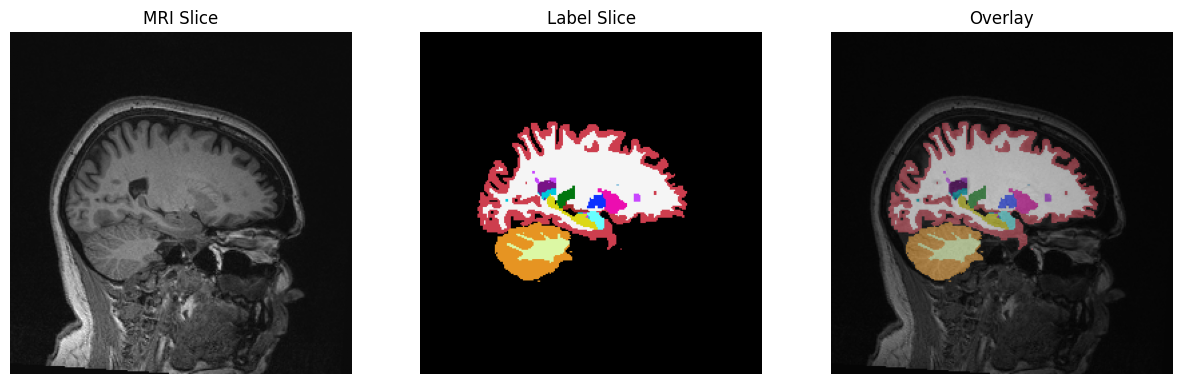

In [7]:
visualize_image(images[245],labels[245], 110)

####Function to make labels contiguous

In [8]:
def replace_freesurfer_index_with_contiguous(seg):
   label_index=np.unique(seg)
   for items in label_index:
     seg[seg==items]=np.where(label_index==items)[0][0]
   return seg

In [9]:
BATCH_SIZE = 1
NUM_CLASSES = 45
ROI_SIZE = (160, 160, 160)
NUM_WORKERS = 2

In [10]:
data_dicts = [
    {"image": img, "label": lbl}
    for img, lbl in zip(images, labels)
]

In [11]:

train_data, test_val_data = train_test_split(data_dicts, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_val_data, test_size=0.5, random_state=42)

##Transforms

In [12]:
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    Lambdad(keys=["label"], func=replace_freesurfer_index_with_contiguous),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
    RandSpatialCropd(keys=["image", "label"], roi_size=ROI_SIZE, random_size=False),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandRotate90d(keys=["image", "label"], prob=0.5, max_k=3),
    ToTensord(keys=["image", "label"]),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    Lambdad(keys=["label"], func=replace_freesurfer_index_with_contiguous),
    Lambda(replace_freesurfer_index_with_contiguous),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
    ToTensord(keys=["image", "label"]),
])

In [13]:
train_ds = Dataset(data=train_data, transform=train_transforms)
val_ds = Dataset(data=val_data, transform=val_transforms)
test_ds = Dataset(data=test_data, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=NUM_WORKERS)

##MODEL

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=ROI_SIZE,
    in_channels=1,
    out_channels=NUM_CLASSES,
    feature_size=24,
    use_checkpoint=True,
).to(device)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [15]:
loss_fn = DiceCELoss(
    softmax=True,
    to_onehot_y=True,
    lambda_dice=0.6,
    lambda_ce=0.4,
)

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)

In [17]:
dice_metric = DiceMetric(include_background=False, reduction="mean")
hd_metric = HausdorffDistanceMetric(include_background=False, percentile=95)

##Functions to load and save model and checkpoints

In [18]:
def save_best_model(model, best_model_path):
    torch.save(model.state_dict(), best_model_path)

In [19]:
def save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path):
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'dice_mean': dice_mean,
    'epoch_list' : epoch_list,
    'val_dice_list' : val_dice_list,
    'train_loss_list' : train_loss_list,
    'best_metric': best_metric,
    'best_metric_epoch': best_metric_epoch,
    }
    torch.save(checkpoint, checkpoint_path)


In [20]:
def load_checkpoint(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    dice_mean = checkpoint['dice_mean']
    epoch_list = checkpoint['epoch_list']
    val_dice_list = checkpoint['val_dice_list']
    train_loss_list = checkpoint['train_loss_list']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    return epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch

##Load Checkpoint

In [21]:
epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch = load_checkpoint('f_feb23_24feature_Checkpoint.pth')

<ipython-input-20-19b8f39b631c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


##Epochs and Validation

In [22]:
max_epochs = 50
val_interval = 1

In [23]:
len(val_dice_list), len(epoch_list)

(18, 18)

###Run if Checkpoints are not loaded

In [23]:
train_loss_list = []
val_dice_list   = []
val_hd95_list = []
epoch_list      = []
dice_mean = -1
best_metric = -1
best_metric_epoch = -1

##Train and Validation Loop

In [24]:
from tqdm import tqdm
import datetime

In [ ]:
checkpoint_path = '2_feb23_24feature_Checkpoint.pth'
best_model_path = '3_feb23_24feature_best_dice_model.pth'

#Training Loop
for epoch in range(epoch+1, max_epochs):
    print(f"Epoch [{epoch+1}/{max_epochs}] {datetime.datetime.now()}")
    model.train()
    epoch_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
        inputs = batch["image"].to(device)
        labels = batch["label"].to(device).long()

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    #scheduler.step()
    train_loss_list.append(epoch_loss)
    print(f"  Train loss: {epoch_loss:.4f}")
    save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path)


    # Validation Loop
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_vals = []
        with torch.no_grad():
            val_inputs = None
            val_labels = None
            val_outputs = None
            for val_data in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False):
                inputs = batch["image"].to(device)
                labels = batch["label"].to(device)

                outputs = sliding_window_inference(
                    inputs,
                    roi_size=ROI_SIZE,
                    sw_batch_size=4,
                    predictor=model,
                    overlap=0.25,
                    mode="gaussian"
                )
                outputs = torch.argmax(outputs, dim=1, keepdim=True)
                dice_metric(y_pred=outputs, y=labels)
                hd_metric(y_pred=outputs, y=labels)


        dice_mean = dice_metric.aggregate().item()
        hd_val = hd_metric.aggregate().item()
        dice_metric.reset()
        hd_metric.reset()
        val_dice_list.append(dice_mean)
       # val_hd95_list.append(hd_val)
        epoch_list.append(epoch + 1)
        print(f"  Val Dice: {dice_mean:.4f}, Val HD95: {hd_val:.2f}")

        # Save the best model
        if dice_mean > best_metric:
            best_metric = dice_mean
            best_metric_epoch = epoch + 1
            save_best_model(model, best_model_path)
            print("   Saved new best model")


print(f"\nTraining complete. Best val Dice: {best_metric:.4f} at epoch {best_metric_epoch}")


Epoch [38/50] 2025-02-24 09:25:20.906806


  Train loss: 0.2166


  Val Dice: 0.7910, Val HD95: 2.00
Epoch [39/50] 2025-02-24 09:43:54.584851


  Train loss: 0.2178


  Val Dice: 0.9289, Val HD95: 1.41
Epoch [40/50] 2025-02-24 09:59:05.470586


  Train loss: 0.2172


  Val Dice: 0.9209, Val HD95: 1.00
Epoch [41/50] 2025-02-24 10:14:14.716607


  Train loss: 0.2240


  Val Dice: 0.9195, Val HD95: 1.73
Epoch [42/50] 2025-02-24 10:29:25.520958


  Train loss: 0.2230


  Val Dice: 0.8411, Val HD95: 2.00
Epoch [43/50] 2025-02-24 10:44:37.530793


Training Epoch 43:  68%|██████▊   | 272/400 [09:28<04:26,  2.08s/it]

##Plotting of Loss Curves

In [41]:
len(train_loss_list), len(val_dice_list), len(epoch_list)

(37, 18, 18)

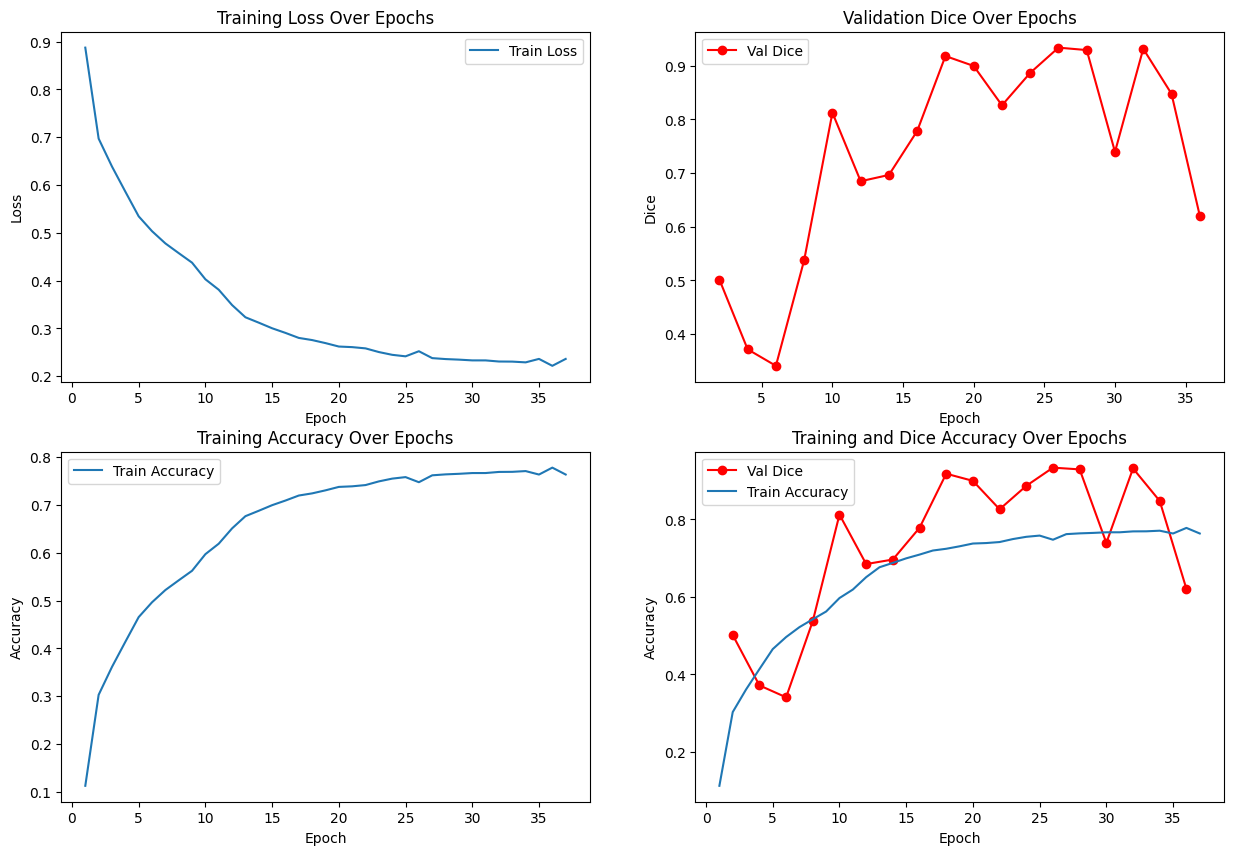

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0 ,0].plot(range(1, 37+1), train_loss_list, label="Train Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Training Loss Over Epochs")
axs[0, 0].legend()

axs[0, 1].plot(epoch_list, val_dice_list, 'r-o', label="Val Dice")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Dice")
axs[0, 1].set_title("Validation Dice Over Epochs")
axs[0, 1].legend()

axs[1, 0].plot(range(1, 37+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Training Accuracy Over Epochs")
axs[1, 0].legend()

axs[1, 1].plot(epoch_list, val_dice_list, 'r-o', label="Val Dice")
axs[1, 1].plot(range(1, 37+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].set_title("Training and Dice Accuracy Over Epochs")
axs[1, 1].legend()

plt.show()

In [21]:
os.listdir()

['Datasets_for_model',
 'FreeSurferColorLUT.txt',
 'Colab Notebooks',
 'checkpoint_jan_01.pth',
 'ALLDATASETS',
 'best_metric_model_jan_01_126.pth',
 'MNI-HISUUB25',
 'image_files',
 'label_files',
 'Checkpoints',
 'MNI_train_data',
 'Checkpoints_hippo',
 'OASIS_500',
 'New_Checkpoints',
 'feb23_24feature_best_dice_model.pth',
 'feb23_24feature_Checkpoint.pth',
 'f_feb23_24feature_Checkpoint.pth',
 '.ipynb_checkpoints',
 'f_feb23_24feature_best_dice_model.pth']

In [36]:
dice_metric.reset()
hd_metric.reset()

In [48]:
# Final Test
c=1
dice_mean=[]
hd95_mean=[]

model.load_state_dict(torch.load('f_feb23_24feature_best_dice_model.pth'))
model.eval()

with torch.no_grad():
    for batch in test_loader:
        inputs = batch["image"].to(device)
        labels = batch["label"].to(device)

        # Use sliding window for full 256x256x256 inference
        outputs = sliding_window_inference(
            inputs, ROI_SIZE, 4, model, overlap=0.25, mode="gaussian"
        )
        outputs = torch.argmax(outputs, dim=1, keepdim=True)

        dice_metric(y_pred=outputs, y=labels)
        hd_metric(y_pred=outputs, y=labels)

        test_dice = dice_metric.aggregate().item()
        test_hd = hd_metric.aggregate().item()
        print(f"Dice: {test_dice:.4f}, HD95: {test_hd:.2f}")

        dice_mean.append(test_dice)
        hd95_mean.append(test_hd)
        dice_metric.reset()
        hd_metric.reset()
        c+=1
        if c==10:
          break

#test_dice = dice_metric.aggregate().item()
#test_hd = hd_metric.aggregate().item()
print(f"\nFinal Test - Dice: {np.mean(dice_mean):.4f}, HD95: {np.mean(hd95_mean):.2f}")

<ipython-input-48-72d8bf01b745>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('f_feb23_24feature_best_dice_model.pth'))


Dice: 0.9140, HD95: 1.73
Dice: 0.8744, HD95: 3.46
Dice: 0.8641, HD95: 27.76
Dice: 0.8959, HD95: 17.23
Dice: 0.8339, HD95: 2.00
Dice: 0.7123, HD95: 15.33
Dice: 0.8445, HD95: 26.85
Dice: 0.8881, HD95: 3.61
Dice: 0.7000, HD95: 15.13

Final Test - Dice: 0.8364, HD95: 12.57


In [38]:
np.mean([1,2])

1.5